# Estimating COVID-19's $R_t$ in Real-Time for EU - results

Data and estimates from April 23. See the `Realtime R0` notebook for how numbers here were derived.

In [24]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

COUNTRIES_INCLUDED = ['Austria', 'Italy', 'Belgium', 'Latvia', 'Bulgaria', 'Lithuania', 'Croatia', 'Luxembourg', 
                      'Cyprus', 'Malta', 'Czechia', 'Netherlands', 'Denmark', 'Poland', 'Estonia', 'Portugal', 
                      'Finland', 'Romania', 'France', 'Slovakia', 'Germany', 'Slovenia', 'Greece', 'Spain', 
                      'Hungary', 'Sweden', 'Ireland', 'Russia', 'Norway', 'Switzerland']

%config InlineBackend.figure_format = 'retina'

In [48]:
def plot_rt(result, ax, country_name):
    
    ax.set_title(f"{country_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 3.0)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

In [26]:
final_results = pd.read_csv('data/rt.csv',
                            parse_dates=['date'],infer_datetime_format=True,
                            index_col=['country', 'date'],
                            squeeze=True)

In [27]:
final_results

ML  Low_90  High_90  Low_50  High_50
country        date                                              
Austria        2020-03-10  3.57    1.60     5.28    2.70     4.21
               2020-03-11  3.55    2.32     4.70    3.03     4.00
               2020-03-12  3.48    2.54     4.34    3.03     3.77
               2020-03-13  3.32    2.56     4.03    2.97     3.57
               2020-03-14  2.93    2.25     3.53    2.63     3.15
...                         ...     ...      ...     ...      ...
United_Kingdom 2020-04-22  0.76    0.59     0.90    0.69     0.81
               2020-04-23  0.88    0.71     1.02    0.81     0.93
               2020-04-24  0.99    0.82     1.13    0.92     1.04
               2020-04-25  1.13    0.95     1.26    1.05     1.17
               2020-04-26  1.15    0.99     1.29    1.07     1.19

[1366 rows x 5 columns]

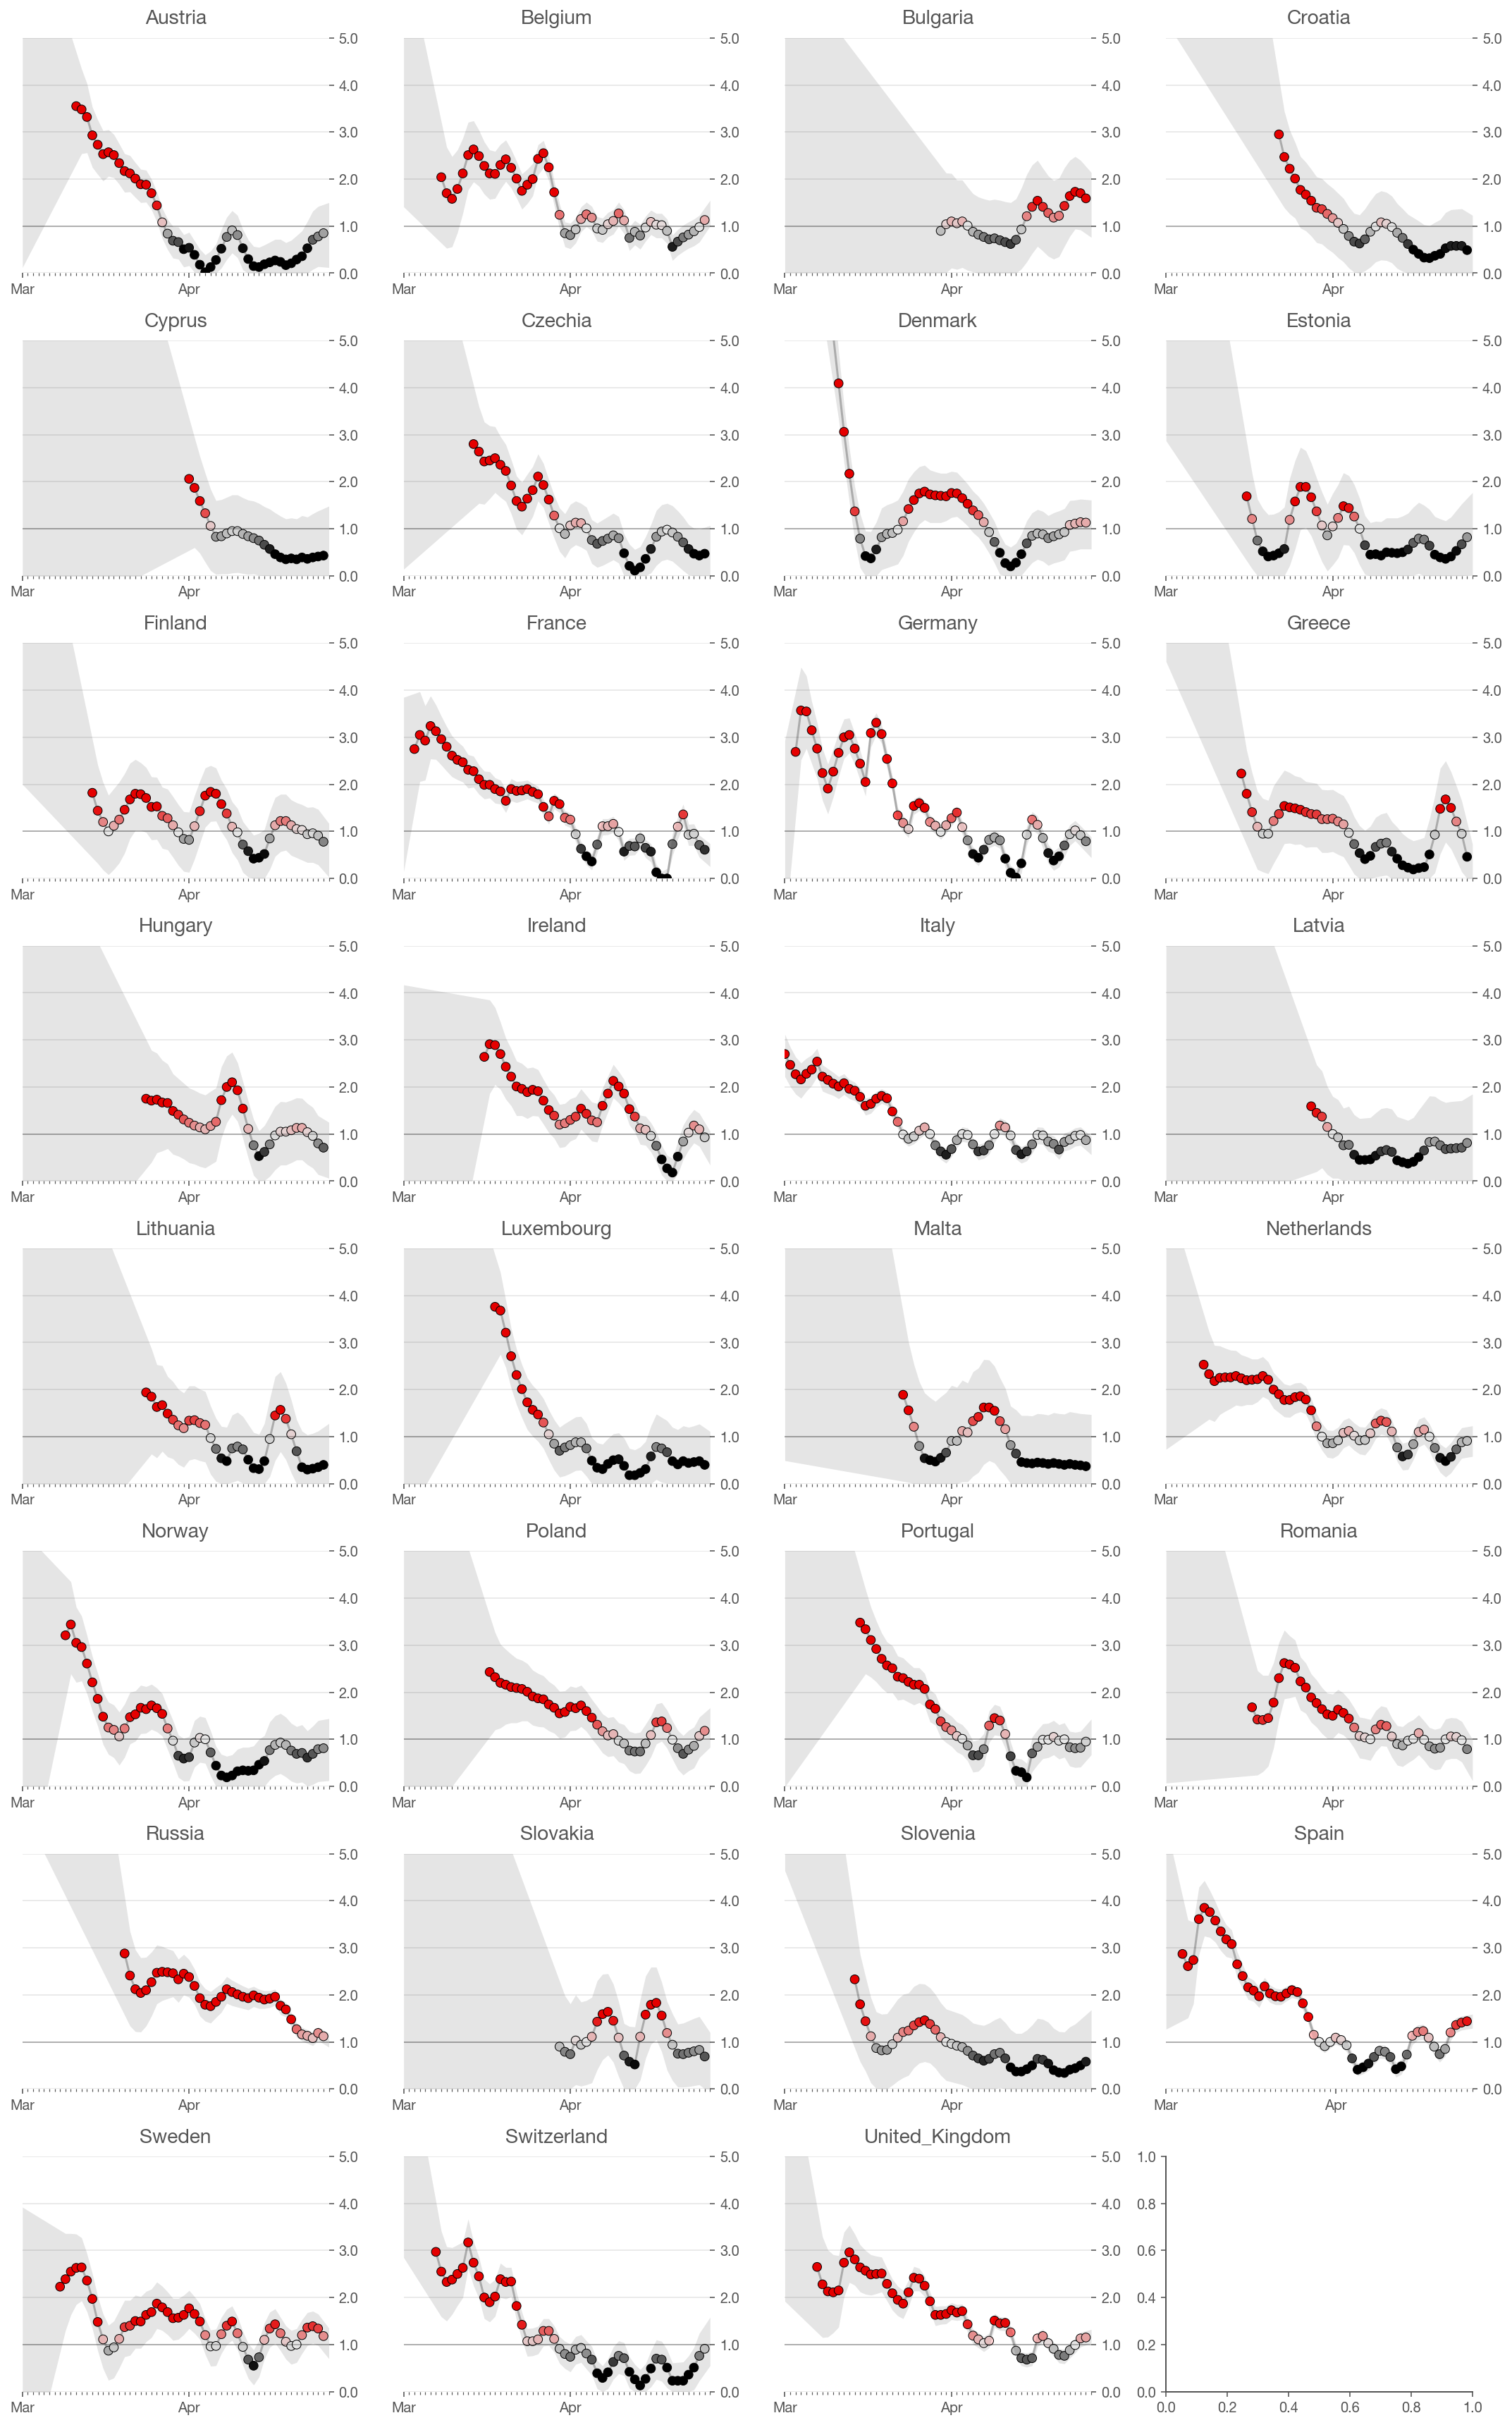

In [28]:
ncountries = len(final_results.index.unique(level='country'))
ncols = 4
nrows = int(np.ceil(ncountries / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (country_name, result) in enumerate(final_results.groupby('country')):
    plot_rt(result.iloc[1:], axes.flat[i], country_name)

fig.tight_layout()
fig.set_facecolor('w')

## Standings

In [29]:
FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]

In [30]:
no_lockdown = []
partial_lockdown = []

In [31]:
final_results_rainier = pd.read_csv('data/rt-rainier.csv', 
                                    parse_dates=['date'],infer_datetime_format=True,
                                    index_col=['country', 'date'],
                                    squeeze=True)

In [32]:
def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by Country'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)

    for bar, country_name in zip(bars, mr.index):
        if country_name in no_lockdown:
            bar.set_color(NONE_COLOR)
        if country_name in partial_lockdown:
            bar.set_color(PARTIAL_COLOR)

    labels = mr.index.to_series().replace({'District of Columbia':'DC'})
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,2.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)

    fig.set_facecolor('w')
    return fig, ax

(<Figure size 671.184x180 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc9692859d0>)

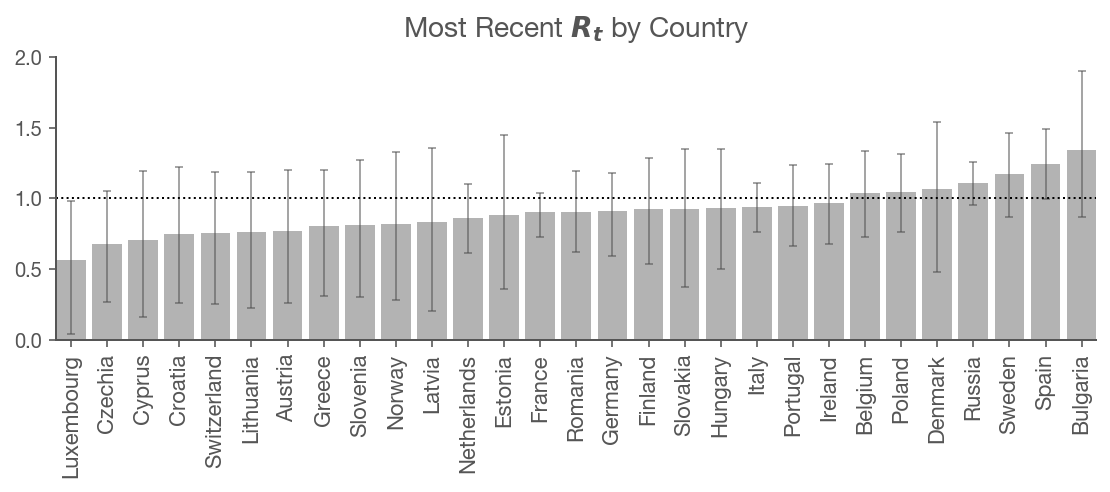

In [33]:
targets_rainier = final_results_rainier.index.get_level_values('country').isin(COUNTRIES_INCLUDED)
mr_rainier = final_results_rainier.loc[targets_rainier].groupby(level=0)[['ML', 'High_90', 'Low_90']].last()

mr_rainier.sort_values('ML', inplace=True)
plot_standings(mr_rainier)

## MCMC

In [36]:
final_results_mcmc = pd.read_csv('data/rt_mcmc.csv',
                            parse_dates=['date'],infer_datetime_format=True,
                            index_col=['region', 'date'],
                            squeeze=True)

In [37]:
final_results_mcmc

mean    median  lower_90  upper_90  lower_50  \
region         date                                                           
Austria        2020-03-09  1.442569  1.401386  1.101776  1.764789  1.222330   
               2020-03-10  1.432523  1.389053  1.113181  1.734709  1.224591   
               2020-03-11  1.410674  1.370391  1.088825  1.693001  1.182064   
               2020-03-12  1.388299  1.363918  1.109086  1.685471  1.210022   
               2020-03-13  1.357950  1.332225  1.097058  1.615022  1.195995   
...                             ...       ...       ...       ...       ...   
United_Kingdom 2020-04-22  1.009294  1.006408  0.915568  1.096752  0.975004   
               2020-04-23  1.014904  1.011662  0.912730  1.110597  0.969640   
               2020-04-24  1.011877  1.010439  0.888576  1.109484  0.978312   
               2020-04-25  1.005932  1.006578  0.866637  1.123540  0.965952   
               2020-04-26  1.008105  1.007493  0.847608  1.152990  0.964920   

                           upper_50  
region         date                  
Austria        2020-03-09  1.478750  
               2020-03-10  1.461555  
               2020-03-11  1.411838  
               2020-03-12  1.424792  
               2020-03-13  1.398578  
...                             ...  
United_Kingdom 2020-04-22  1.034777  
               2020-04-23  1.035126  
               2020-04-24  1.054479  
               2020-04-25  1.051956  
               2020-04-26  1.065485  

[1519 rows x 6 columns]

In [42]:
final_results_mcmc.columns = ['mean', 'ML', 'Low_90', 'High_90', 'Low_50', 'High_50']

In [43]:
final_results_mcmc

mean        ML    Low_90   High_90    Low_50  \
region         date                                                           
Austria        2020-03-09  1.442569  1.401386  1.101776  1.764789  1.222330   
               2020-03-10  1.432523  1.389053  1.113181  1.734709  1.224591   
               2020-03-11  1.410674  1.370391  1.088825  1.693001  1.182064   
               2020-03-12  1.388299  1.363918  1.109086  1.685471  1.210022   
               2020-03-13  1.357950  1.332225  1.097058  1.615022  1.195995   
...                             ...       ...       ...       ...       ...   
United_Kingdom 2020-04-22  1.009294  1.006408  0.915568  1.096752  0.975004   
               2020-04-23  1.014904  1.011662  0.912730  1.110597  0.969640   
               2020-04-24  1.011877  1.010439  0.888576  1.109484  0.978312   
               2020-04-25  1.005932  1.006578  0.866637  1.123540  0.965952   
               2020-04-26  1.008105  1.007493  0.847608  1.152990  0.964920   

                            High_50  
region         date                  
Austria        2020-03-09  1.478750  
               2020-03-10  1.461555  
               2020-03-11  1.411838  
               2020-03-12  1.424792  
               2020-03-13  1.398578  
...                             ...  
United_Kingdom 2020-04-22  1.034777  
               2020-04-23  1.035126  
               2020-04-24  1.054479  
               2020-04-25  1.051956  
               2020-04-26  1.065485  

[1519 rows x 6 columns]

(<Figure size 694.08x180 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc95a76f8e0>)

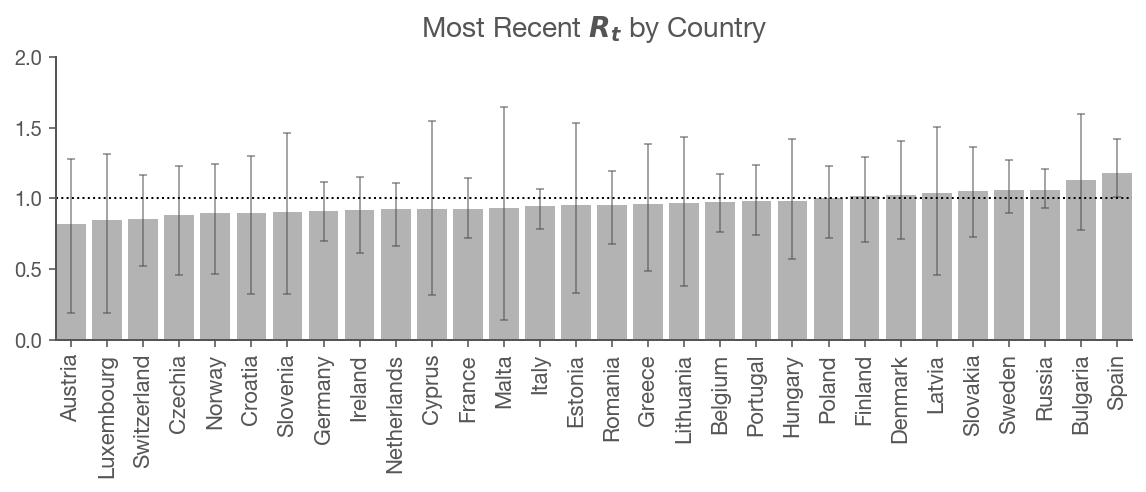

In [44]:
targets_mcmc = final_results_mcmc.index.get_level_values('region').isin(COUNTRIES_INCLUDED)
mr_mcmc = final_results_mcmc.loc[targets_mcmc].groupby(level=0)[['ML', 'High_90', 'Low_90']].last()

mr_mcmc.sort_values('ML', inplace=True)
plot_standings(mr_mcmc)

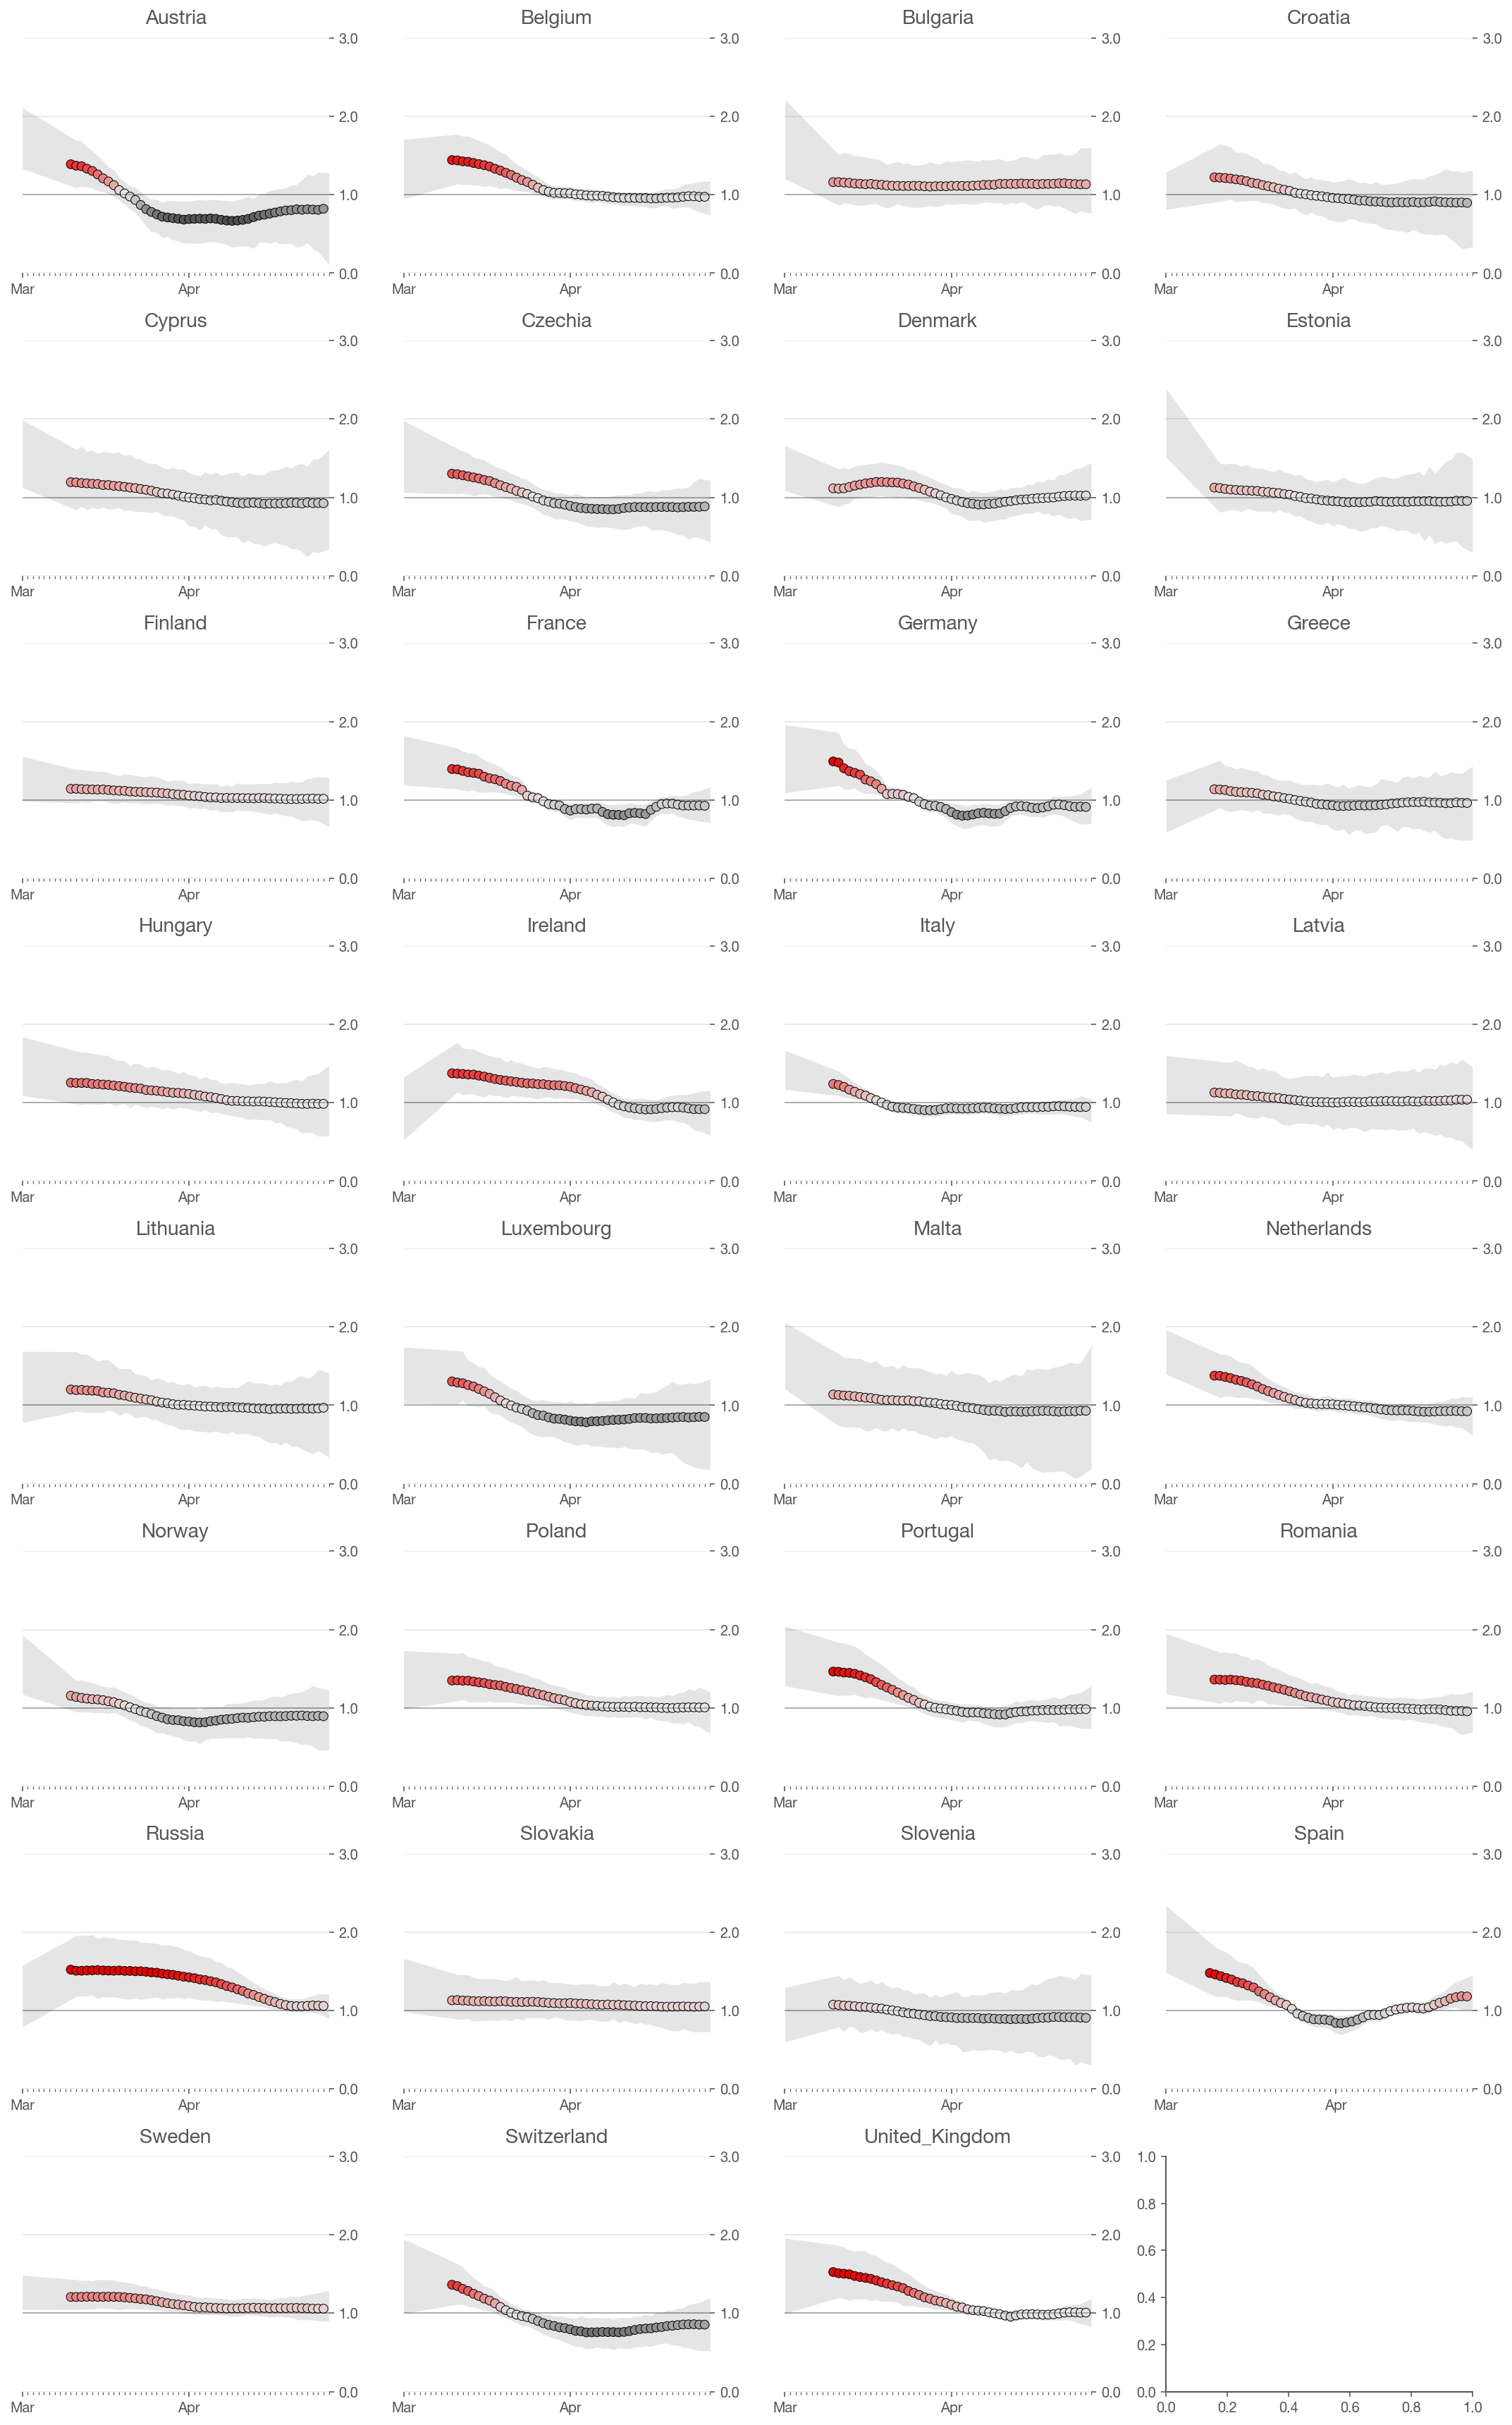

In [49]:
ncountries = len(final_results_mcmc.index.unique(level='region'))
ncols = 4
nrows = int(np.ceil(ncountries / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (country_name, result) in enumerate(final_results_mcmc.groupby('region')):
    plot_rt(result.iloc[1:], axes.flat[i], country_name)

fig.tight_layout()
fig.set_facecolor('w')